# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

Input arguments checking

In [3]:
def checkPlayInput(tround, context, narms, ndims):
    assert isinstance(tround, np.int) and tround > 0
    if ndims is None:
        assert context is None or isinstance(context, np.ndarray) \
            and context.size % narms == 0 and context.dtype == np.float
    else:
        assert isinstance(ndims, np.int) and ndims > 0
        assert context is None or isinstance(context, np.ndarray) \
            and context.shape == (ndims * narms, ) and context.dtype == np.float

def checkUpdateInput(arm, reward, context, narms, ndims):
    assert (isinstance(arm, np.int) or isinstance(arm, np.int32)) and arm > 0 and arm <= narms
    assert isinstance(reward, np.float)
    if ndims is None:
        assert context is None or isinstance(context, np.ndarray) \
            and context.size % narms == 0 and context.dtype == np.float
    else:
        assert isinstance(ndims, np.int) and ndims > 0
        assert context is None or isinstance(context, np.ndarray) \
            and context.shape == (ndims * narms, ) and context.dtype == np.float
        

Looking for the argmax of numpy array. If there are multiple maximum values, pick a random index.

In [4]:
def randomArgMax(value):
    assert isinstance(value, np.ndarray) and value.ndim == 1
    ''' All nan in array '''
    if np.isnan(value).sum() == len(value):
        return np.random.randint(len(value)) + 1
    indexes = np.where(value == np.max(value))
    return np.random.choice(indexes[0]) + 1

In [5]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        assert isinstance(narms, np.int) and narms > 0
        assert isinstance(epsilon, np.float) and epsilon >= 0 and epsilon <= 1
        assert isinstance(Q0, np.float)
        self.narms = narms
        self.epsilon = epsilon
        self.values = np.ones(narms) * Q0
        self.counts = np.zeros(narms, dtype=np.int)
        self.bonus = np.zeros(narms)
        
    def play(self, tround, context=None):
        # Check the input 
        checkPlayInput(tround, context, self.narms, None)
        
        if np.random.random() < self.epsilon:
            return np.random.randint(self.narms) + 1
        else:
            return randomArgMax(self.values)     
        
    def update(self, arm, reward, context=None):
        # Check the input 
        checkUpdateInput(arm, reward, context, self.narms, None)
        
        self.counts[arm - 1] += 1
        if self.counts[arm - 1] == 1:
            self.values[arm - 1] = reward
        else:
            self.values[arm - 1] = (self.values[arm - 1] * (self.counts[arm - 1] - 1)+ reward) / self.counts[arm - 1]


In [6]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert isinstance(narms, np.int) and narms > 0
        assert isinstance(rho, np.float) and rho > 0
        assert isinstance(Q0, np.float)
        self.narms = narms
        self.rho = rho
        self.values = np.ones(narms) * Q0
        self.counts = np.zeros(narms, dtype=np.int)
        
    def play(self, tround, context=None):
        # Check the input 
        checkPlayInput(tround, context, self.narms, None)
        
        np.seterr(divide='ignore', invalid='ignore')
        qValues = self.values + np.divide(np.sqrt(self.rho * np.log(tround)), np.sqrt(self.counts))
        return randomArgMax(qValues)
        
    def update(self, arm, reward, context=None):
        # Check the input 
        checkUpdateInput(arm, reward, context, self.narms, None)
        
        self.counts[arm - 1] += 1
        if self.counts[arm - 1] == 1:
            self.values[arm - 1] = reward
        else:
            self.values[arm - 1] = (self.values[arm - 1] * (self.counts[arm - 1] - 1)+ reward) / float(self.counts[arm - 1])
            

## 2. The Basic Thompson Bandit

In [7]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        assert isinstance(narms, np.int) and narms > 0
        assert isinstance(alpha0, np.float) and alpha0 > 0
        assert isinstance(beta0, np.float) and beta0 > 0
        self.narms = narms
        self.alpha = np.ones(narms) * alpha0
        self.beta = np.ones(narms) * beta0
    
    def play(self, tround, context=None):
        # Check the input 
        checkPlayInput(tround, context, self.narms, None)
        
        theta = np.array([np.random.beta(self.alpha[arm], self.beta[arm]) for arm in range(self.narms)], dtype = np.float)
        return randomArgMax(theta)             
        
    def update(self, arm, reward, context=None):
        # Check the input 
        checkUpdateInput(arm, reward, context, self.narms, None)
        
        if reward == 1:
            self.alpha[arm - 1] += 1
        else:
            self.beta[arm - 1] += 1

## 3. Off-Policy Evaluation

In [8]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    assert isinstance(mab, MAB)
    assert isinstance(arms, np.ndarray) and arms.ndim == 1 and arms.dtype == np.int
    assert isinstance(rewards, np.ndarray) and rewards.ndim == 1 and rewards.dtype == np.float
    assert isinstance(contexts, np.ndarray) and contexts.ndim == 2 and contexts.dtype == np.float
    assert nrounds is None or isinstance(nrounds, np.int) 
    
    row = 0
    rewardList = []
    try:
        for tround in range(1, nrounds + 1):
            arm = arms[row]
            while mab.play(tround, contexts[row]) != arm:
                row += 1
                arm = arms[row]
            mab.update(arm, rewards[row], contexts[row])
            rewardList.append(rewards[row])
            row += 1
    except IndexError:
        pass
    return np.array(rewardList, dtype = np.float)

In [9]:
data = np.loadtxt('dataset.txt', dtype = np.float)
arms = data[:,0].astype(np.int)
rewards = data[:,1]
contexts = data[:,2::] 

In [10]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.265


In [11]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.18375


In [12]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.2175


## 4. Contextual Bandits - LinUCB

In [13]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert isinstance(narms, np.int) and narms > 0
        assert isinstance(ndims, np.int) and ndims > 0
        assert isinstance(alpha, np.float) and alpha > 0
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A = [np.identity(ndims) for arm in range(narms)]
        self.b = [np.zeros((ndims, 1)) for arm in range(narms)]
        
    def play(self, tround, context):
        # Check the input 
        checkPlayInput(tround, context, self.narms, self.ndims)
        
        theta = [inv(self.A[arm]) @ self.b[arm] for arm in range(self.narms)]
        xt = context.reshape(self.narms, self.ndims, 1)
        pt = [theta[arm].T @ xt[arm] 
              + self.alpha * np.sqrt(xt[arm].T @ inv(self.A[arm]) @ xt[arm]) 
              for arm in range(self.narms)]
        pt = np.squeeze(np.array(pt))
        return randomArgMax(pt) 
        
    def update(self, arm, reward, context):
        # Check the input 
        checkUpdateInput(arm, reward, context, self.narms, self.ndims)
        
        xt = context.reshape(self.narms, self.ndims, 1)
        self.A[arm - 1] = self.A[arm - 1] + xt[arm - 1] @ xt[arm - 1].T
        self.b[arm - 1] = self.b[arm - 1] + reward * xt[arm - 1]
        
    

In [14]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [15]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        assert isinstance(narms, np.int) and narms > 0
        assert isinstance(ndims, np.int) and ndims > 0
        assert isinstance(v, np.float) and v > 0
        
        self.narms = narms
        self.ndims = ndims
        self.v = v
        self.B = np.identity(ndims)
        self.mu = np.zeros(ndims)
        self.f = np.zeros(ndims)
        
    def play(self, tround, context):
        # Check the input 
        checkPlayInput(tround, context, self.narms, self.ndims)
        
        mut = np.random.multivariate_normal(self.mu, self.v ** 2 * inv(self.B))
        bt = context.reshape(self.narms, self.ndims)
        value = np.squeeze(bt @ mut)
        return randomArgMax(bt @ mut)
    
    def update(self, arm, reward, context):
        # Check the input 
        checkUpdateInput(arm, reward, context, self.narms, self.ndims)
        
        bt = context.reshape(self.narms, self.ndims)
        self.B += np.outer(bt[arm - 1], bt[arm - 1])
        self.f += bt[arm - 1] * reward
        self.mu = inv(self.B) @ self.f

In [16]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.33


## 6. Evaluation
### 6.A.

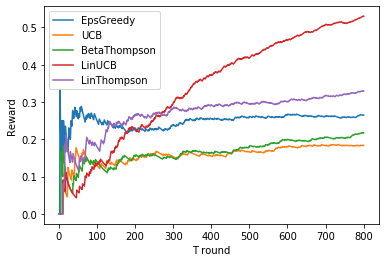

In [17]:
for mab in ['EpsGreedy', 'UCB', 'BetaThompson', 'LinUCB', 'LinThompson']:
    results = eval('results_' + mab)
    tround = np.arange(1, len(results) + 1)
    cumsum = np.cumsum(results)/tround
    plt.plot(tround, cumsum, label=mab)
plt.legend()
plt.xlabel('T round')
plt.ylabel('Reward')
plt.show()

### 6.B.

#### 6.B.1 Hyperparameters $\alpha$ in LinUCB

According to the paper, hyperparameters $\alpha$ is calculated with confidence level $1 - \delta$,  which is $$\alpha = 1 + \sqrt{\frac{\log{\frac{2}{\delta}}}{2}}$$
As $\delta$ is between 0 and 1, I generate a hundred of different $\delta$ to get $\alpha$ and take the rewards after 800 rounds. 
The result is as shown below.

In [18]:
deltas = np.linspace(0.01, 1, 100)
alphas = 1 + np.sqrt(np.log(2/deltas) / 2)
reward_LinUCB = []
for i, alpha in enumerate(alphas):
    mab = LinUCB(10, 10, alpha)
    reward_LinUCB.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))

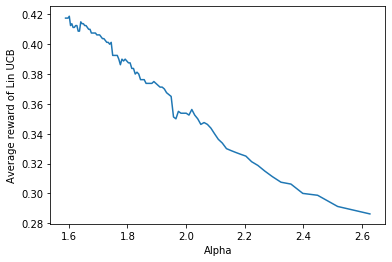

The optimal alpha is 1.601500784722952 and the maximum average reward is 0.41875


In [19]:
plt.plot(alphas, reward_LinUCB)
plt.xlabel('Alpha')
plt.ylabel('Average reward of Lin UCB')
plt.show()
print('The optimal alpha is', alphas[np.argmax(reward_LinUCB)], 'and the maximum average reward is', np.amax(reward_LinUCB))

#### 6.B.1 Hyperparameters $v$ in LinThompson

In paper, hyperparameters $v$ is controlled by three parameters, $\epsilon$, $\delta$ and $R$. $$v = R\sqrt{\frac{24}{\epsilon}d\log{\frac{1}{\delta}}}$$
where d is the number of features.
In this section, I fixed $\delta = 0.05$, $\epsilon = 800$ (total number of rounds to be played), so I adjust $R$ to explore optimal hyperparameters, where $R$ is from 0.1 to 99. The result is as shown below.

In [20]:
R = np.linspace(0.1, 99, 100)
d = 10
delta = 0.05
epsilon = 800
vs = R * np.sqrt(24/epsilon * d * np.log(1/delta))
reward_LinThompson = []
for i, v in enumerate(vs):
    mab = LinThompson(10, 10, v)
    reward_LinThompson.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))

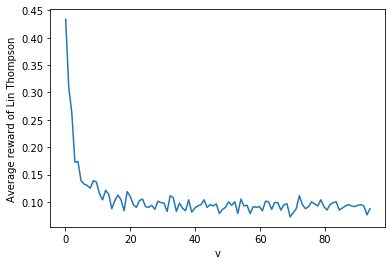

The optimal v is 0.09480082710958788 and the maximum average reward is 0.43375


In [21]:
plt.plot(vs, reward_LinThompson)
plt.xlabel('v')
plt.ylabel('Average reward of Lin Thompson')
plt.show()
print('The optimal v is', vs[np.argmax(reward_LinThompson)], 'and the maximum average reward is', np.amax(reward_LinThompson))

Therefore, the smaller both $\alpha$ and $v$ are, the better reward LinUCB and LinThompson get respectively.